In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.svm import SVC

# dimensionality reduction
from sklearn.decomposition import PCA
from featurewiz import featurewiz

from ipynb.fs.full.Functions import load_train_test_data, model_eval, run_gridsearchCV, load_model, feature_importance

Imported 0.2.8 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



# RBF-SVM with 1-1 
## Only 6 parameters
According to paper 4: Luengo et al. (2005). "Automatic Emotion Recognition using Prosodic Parameters"

In [2]:
# load the data
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')
df.columns

Index(['duration', 'mean', 'median', 'max', 'min', 'var', 'std',
       'speaking_rate', 'articulation_rate', 'asd',
       ...
       'lpcmfccs_local9_min', 'lpcmfccs_local10_mean', 'lpcmfccs_local10_var',
       'lpcmfccs_local10_max', 'lpcmfccs_local10_min', 'lpcmfccs_local11_mean',
       'lpcmfccs_local11_var', 'lpcmfccs_local11_max', 'lpcmfccs_local11_min',
       'label'],
      dtype='object', length=250)

In [3]:
# selection of features (mean pitch, mean energy, pitch variance, skew of logarithmic pitch, range of logarithmic pitch,
# range of logarithmic energy)
df6param = df[['label','pitch_mean', 'pitch_var', 'energy_mean', 'skew_log_pitch', 'range_log_pitch', 'range_log_energy']].copy()
df6param.head()

,label,pitch_mean,pitch_var,energy_mean,skew_log_pitch,range_log_pitch,range_log_energy
0,4,-0.741135,-0.527264,-0.181987,-0.296694,-0.600449,0.125001
1,5,-1.386939,-1.070989,0.237872,-0.198081,-1.185553,0.125309
2,0,-0.448158,-0.159707,0.165869,-0.030373,-0.662848,0.131056
3,4,0.445340,0.432260,0.621608,-0.401886,-0.186604,0.114911
4,5,-1.177707,-1.082482,1.031302,-0.559679,-1.360023,0.112277


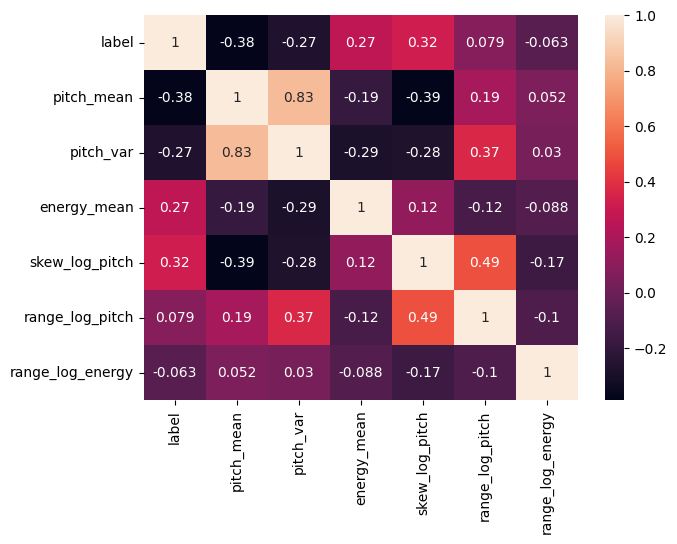

In [4]:
# look at the correlation of the data
plt.figure(figsize=(7,5))
sns.heatmap(df6param.corr(), annot=True)
plt.show()

We can see that *pitch_var* and *pitch_mean* show a highl positive correlation. *skew_log_pitch* and *range_log_pitch* are also positively correlated. 

In [5]:
# Load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df6param)

A snippet of the training data:


,pitch_mean,pitch_var,energy_mean,skew_log_pitch,range_log_pitch,range_log_energy
241,-1.455074,-1.205638,1.184469,-0.294200,-1.483766,-0.154248
364,-0.605954,-0.620878,-1.575339,0.617414,1.926389,0.103658
209,-0.629998,-0.598067,-1.598139,0.587535,0.091817,0.130748
430,0.611862,0.207716,-0.070193,-0.201563,-0.204404,0.130406
309,0.686027,0.723976,0.775073,-0.145928,-0.511626,0.113201


There are 454 entries with 6 columns in the training data.
There are 81 entries with 6 columns in the testing data.


In [6]:
svm_model = SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', decision_function_shape='ovo', gamma=0.1)


Evaluation: f1_score
54.62% for the train data
45.24% for the test data

Evaluation: accuracy_score
55.95% for the train data
48.15% for the test data

Evaluation: precision_score
57.07% for the train data
47.20% for the test data

Evaluation: recall_score
55.09% for the train data
48.13% for the test data

Evaluation: confusion_matrix of test predictions


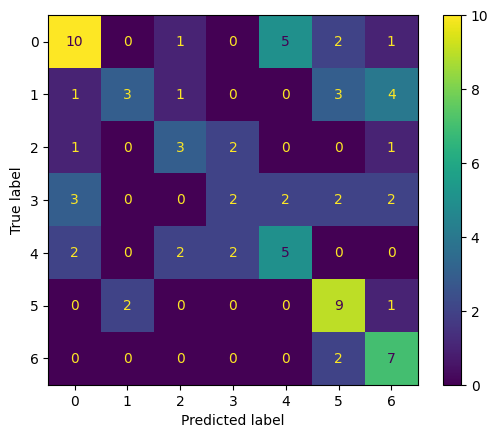


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)', 'sadness(6)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['disgust(2)', 'happiness(4)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['boredom(1)']



In [7]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

A snippet of the training data:


,pitch_mean,energy_mean,range_log_pitch,range_log_energy
241,-1.455074,1.184469,-1.483766,-0.154248
364,-0.605954,-1.575339,1.926389,0.103658
209,-0.629998,-1.598139,0.091817,0.130748
430,0.611862,-0.070193,-0.204404,0.130406
309,0.686027,0.775073,-0.511626,0.113201


There are 454 entries with 4 columns in the training data.
There are 81 entries with 4 columns in the testing data.

Evaluation: f1_score
40.52% for the train data
31.60% for the test data

Evaluation: accuracy_score
42.51% for the train data
34.57% for the test data

Evaluation: precision_score
40.85% for the train data
32.98% for the test data

Evaluation: recall_score
40.81% for the train data
33.25% for the test data

Evaluation: confusion_matrix of test predictions


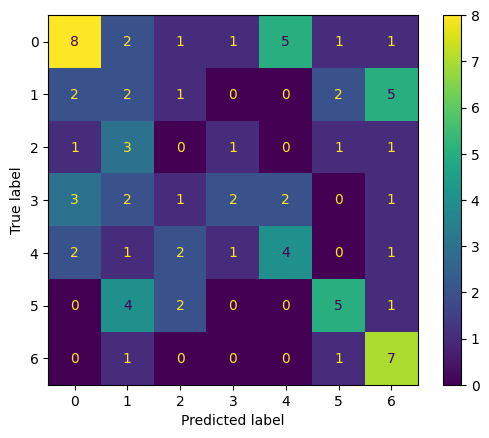


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['sadness(6)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['happiness(4)', 'neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false positives: ['boredom(1)']



In [8]:
# drop correlated features and run again
df6param_uncor = df6param.drop(columns=['pitch_var', 'skew_log_pitch'])
# Load the train/test data
X_train_uncor, X_test_uncor, y_train_uncor, y_test_uncor = load_train_test_data(df6param_uncor)
svm_model.fit(X_train_uncor, y_train_uncor)
model_eval(svm_model, X_train_uncor, X_test_uncor, y_train_uncor, y_test_uncor, confusion=True)

Actually performs worse when dropping these features. 
Next, we try to boost this very simple model with a gridsearch.

### Hyperparameter Optimization

In [13]:
# define the grid for the hyperparameter search
grid_vals = { 'C': [0.01, 0.1, 1, 10], 
            'gamma': [0.01, 0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'class_weight': ['balanced', None], 
            'decision_function_shape': ['ovo', 'ovr']
            }
run_gridsearchCV(svm_model, grid_vals, X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_we

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=poly; total time=   0.4s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=poly; total time=   0.8s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linea

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.5s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.4s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.4s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.7s
[CV] 

[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=poly; total time=   0.5s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=poly; total time=   0.5s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=poly; total time=   0.7s
[CV] END C=0.01, class_weight=None, deci

[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.4s
[CV] END C=0.01, class_weight=None, 

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV]

[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_sh

[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=o

[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balance

[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class

[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shap

[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_functio

[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0

[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   

[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, deci

[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_fun


Evaluation: f1_score
51.11% for the train data
43.39% for the test data

Evaluation: accuracy_score
51.54% for the train data
44.44% for the test data

Evaluation: precision_score
51.58% for the train data
44.66% for the test data

Evaluation: recall_score
52.37% for the train data
45.83% for the test data

Evaluation: confusion_matrix of test predictions


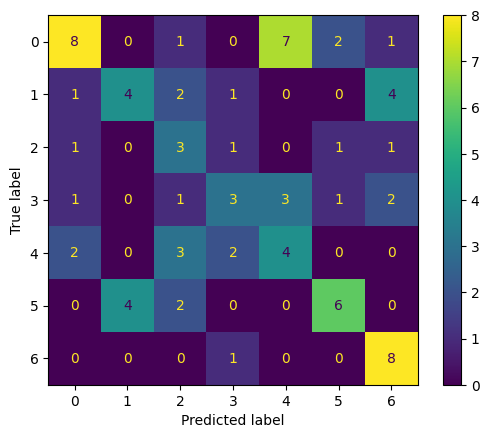


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['sadness(6)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false positives: ['happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['happiness(4)']
Hard cases of false positives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['disgust(2)']
Hard cases of false positives: ['anger(0)', 'fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false positives: ['boredom(1)']



In [14]:
svm_best_model = load_model(svm_model, 'f1_macro')
model_eval(svm_best_model,X_train, X_test, y_train, y_test, confusion=True)

# SVM 
###  Shen et al. (2011) "Automatic Speech Emotion Recognition Using Support Vector Machine" (Paper 3)

In [2]:
# load the data
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')
df.columns

Index(['duration', 'mean', 'median', 'max', 'min', 'var', 'std',
       'speaking_rate', 'articulation_rate', 'asd',
       ...
       'lpcmfccs_local9_min', 'lpcmfccs_local10_mean', 'lpcmfccs_local10_var',
       'lpcmfccs_local10_max', 'lpcmfccs_local10_min', 'lpcmfccs_local11_mean',
       'lpcmfccs_local11_var', 'lpcmfccs_local11_max', 'lpcmfccs_local11_min',
       'label'],
      dtype='object', length=250)

In [3]:
# selection of features: 
# energy features (19-dim), pitch features (19-dim), LPCCs (48-dim), MFCCs (52-dim), LPCMFCCs (48-dim) 
# -> 186 features + label
df_3 = df.filter(regex='energy_|pitch_|lpccs_|^mfccs|lpcmfccs_|label')
df_3.columns

Index(['energy_max', 'energy_mean', 'energy_var', 'energy_rising_duration_max',
       'energy_rising_duration_mean', 'energy_rising_duration_median',
       'energy_rising_duration_iqr', 'energy_falling_duration_max',
       'energy_falling_duration_mean', 'energy_falling_duration_median',
       ...
       'lpcmfccs_local9_min', 'lpcmfccs_local10_mean', 'lpcmfccs_local10_var',
       'lpcmfccs_local10_max', 'lpcmfccs_local10_min', 'lpcmfccs_local11_mean',
       'lpcmfccs_local11_var', 'lpcmfccs_local11_max', 'lpcmfccs_local11_min',
       'label'],
      dtype='object', length=187)

In [6]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3)

A snippet of the training data:


,energy_max,energy_mean,energy_var,energy_rising_duration_max,energy_rising_duration_mean,energy_rising_duration_median,energy_rising_duration_iqr,energy_falling_duration_max,energy_falling_duration_mean,energy_falling_duration_median,...,lpcmfccs_local9_max,lpcmfccs_local9_min,lpcmfccs_local10_mean,lpcmfccs_local10_var,lpcmfccs_local10_max,lpcmfccs_local10_min,lpcmfccs_local11_mean,lpcmfccs_local11_var,lpcmfccs_local11_max,lpcmfccs_local11_min
241,0.109759,1.184469,1.719364,-0.317983,-1.221313,-1.011377,-0.026398,-0.931386,-0.958430,-0.022437,...,-0.308694,0.084472,0.271426,-0.218007,-0.057589,0.313795,0.267861,-0.227202,-0.111190,0.307516
364,-0.957895,-1.575339,-1.830023,-0.317983,-1.094613,-0.403414,-0.297992,-1.288073,-0.602240,0.609351,...,0.711811,-0.075413,-0.780710,-0.043641,0.130479,-0.665620,-0.891269,-0.010428,0.017714,-0.722238
209,-0.957895,-1.598139,-1.561260,-0.790542,-0.346797,0.812510,-0.841179,-1.288073,-0.941656,0.609351,...,1.255242,0.065525,-0.731827,0.102518,-0.035001,-1.208029,-0.794909,0.149507,-0.097226,-1.265853
430,-0.957895,-0.070193,-0.489470,-1.263100,-0.811046,0.812510,-0.297992,-1.288073,-0.852198,0.609351,...,-0.570754,-0.120425,0.484469,-0.230758,0.181230,0.541156,0.519439,-0.246612,0.057740,0.577385
309,2.245066,0.775073,0.472092,1.099692,-0.354158,-0.403414,1.331571,-1.288073,-1.393016,-1.917803,...,-0.591040,0.194870,0.515836,-0.230930,-0.206997,0.556228,0.565981,-0.247006,-0.185268,0.598848


There are 454 entries with 186 columns in the training data.
There are 81 entries with 186 columns in the testing data.


In [7]:
svm_model = SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', decision_function_shape='ovo', gamma=0.1)


Evaluation: f1_score
100.00% for the train data
5.43% for the test data

Evaluation: accuracy_score
100.00% for the train data
23.46% for the test data

Evaluation: precision_score
100.00% for the train data
3.35% for the test data

Evaluation: recall_score
100.00% for the train data
14.29% for the test data

Evaluation: confusion_matrix of test predictions


C:\Users\Kim-Carolin\anaconda3\envs\automatic_speech_emotion_recognition\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


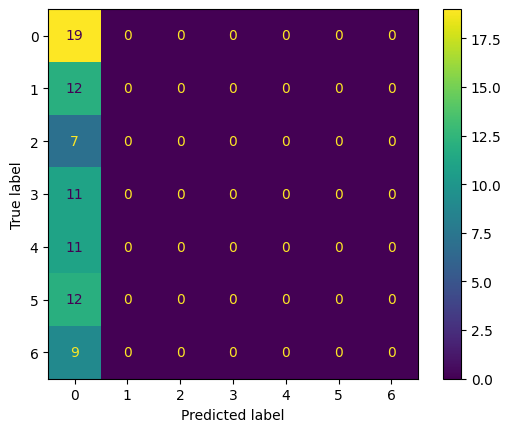


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['anger(0)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['anger(0)']

Label: sadness(6)
Hard cases of false negatives: ['anger(0)']



In [8]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

In [9]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
94.13% for the train data
72.80% for the test data

Evaluation: accuracy_score
94.05% for the train data
74.07% for the test data

Evaluation: precision_score
95.06% for the train data
77.43% for the test data

Evaluation: recall_score
93.51% for the train data
71.12% for the test data

Evaluation: confusion_matrix of test predictions


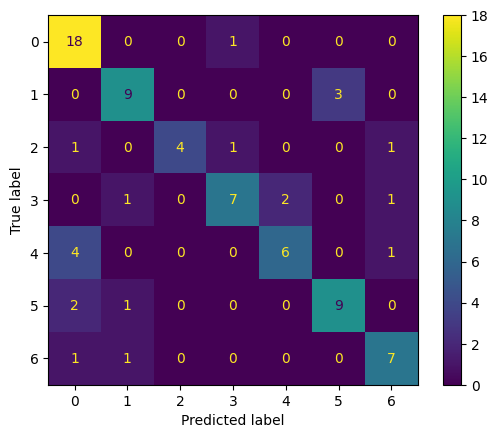


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [10]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

This is actually a really good result! We achieve 94.13% F1 macro on train set and 72.80% on the test set.

### Try with 90-10 train-test split as in paper

In [11]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3, test_size=0.1)

A snippet of the training data:


,energy_max,energy_mean,energy_var,energy_rising_duration_max,energy_rising_duration_mean,energy_rising_duration_median,energy_rising_duration_iqr,energy_falling_duration_max,energy_falling_duration_mean,energy_falling_duration_median,...,lpcmfccs_local9_max,lpcmfccs_local9_min,lpcmfccs_local10_mean,lpcmfccs_local10_var,lpcmfccs_local10_max,lpcmfccs_local10_min,lpcmfccs_local11_mean,lpcmfccs_local11_var,lpcmfccs_local11_max,lpcmfccs_local11_min
237,0.109759,0.171386,0.237628,0.627134,-0.605913,-1.619339,0.245196,0.852048,0.507574,-0.022437,...,-0.195091,0.181742,0.336446,-0.217264,-0.207184,0.209326,0.351303,-0.227112,-0.166875,0.191852
459,-0.957895,0.300091,-0.525615,-0.790542,-0.605913,-0.403414,-0.569585,-0.218012,-1.149648,-1.917803,...,-0.582417,0.199928,0.503072,-0.230901,-0.208053,0.550008,0.544656,-0.246933,-0.195199,0.589683
142,-0.957895,1.185660,0.922756,-0.317983,-0.315307,0.812510,-0.297992,-0.574699,-0.427269,-0.022437,...,0.576409,0.176065,-0.780526,0.008446,-0.190744,-0.532065,-0.872273,0.049954,-0.160583,-0.586427
148,0.109759,0.104880,-1.020438,1.099692,0.844674,-0.403414,-0.297992,1.922108,2.183007,0.609351,...,2.640015,0.174058,-2.495015,1.687736,-0.185442,-2.621600,-2.503976,1.818091,-0.169745,-2.643904
124,-0.957895,-1.492359,-1.505395,-0.790542,-0.034469,0.812510,-1.384366,0.138674,-0.639733,-0.654226,...,-0.036084,-0.445666,0.079640,-0.194174,0.541278,0.060275,0.040702,-0.196731,0.345734,0.030599


There are 481 entries with 186 columns in the training data.
There are 54 entries with 186 columns in the testing data.


In [12]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
93.33% for the train data
72.99% for the test data

Evaluation: accuracy_score
93.35% for the train data
74.07% for the test data

Evaluation: precision_score
94.40% for the train data
76.13% for the test data

Evaluation: recall_score
92.60% for the train data
72.23% for the test data

Evaluation: confusion_matrix of test predictions


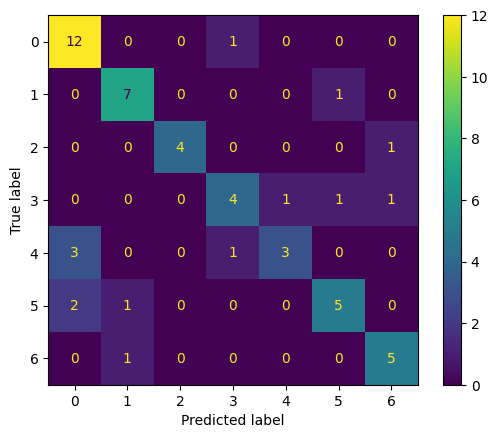


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['anger(0)']



In [13]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

The model is actually a bit better with a 85-15 train-test split. Just the hard cases change slightly.

### Try with 5 emotions only as in paper

In [4]:
# load the data
df_5emos = pd.read_pickle('../results/df_prep_5emos_numerical_only.pkl')

# selection of features
df_5emos = df_5emos.filter(regex='energy_|pitch_|lpccs_|^mfccs|lpcmfccs_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos)

A snippet of the training data:


,energy_max,energy_mean,energy_var,energy_rising_duration_max,energy_rising_duration_mean,energy_rising_duration_median,energy_rising_duration_iqr,energy_falling_duration_max,energy_falling_duration_mean,energy_falling_duration_median,...,lpcmfccs_local9_max,lpcmfccs_local9_min,lpcmfccs_local10_mean,lpcmfccs_local10_var,lpcmfccs_local10_max,lpcmfccs_local10_min,lpcmfccs_local11_mean,lpcmfccs_local11_var,lpcmfccs_local11_max,lpcmfccs_local11_min
121,-0.959314,-0.341210,0.157216,0.089574,-0.213874,-0.346349,-0.382494,0.388276,-0.278035,-0.710346,...,1.327561,0.193975,-1.469343,0.404402,-0.199982,-1.292353,-1.568698,0.480893,-0.201294,-1.335401
211,0.173813,1.457029,-0.255004,0.089574,-0.518771,-0.346349,-0.382494,4.081847,0.995960,-0.710346,...,-0.626460,0.195514,0.494667,-0.249350,-0.200395,0.600694,0.522463,-0.265745,-0.175649,0.632186
214,0.173813,0.244975,0.202045,-0.384886,-0.636040,-0.346349,-0.923894,0.388276,-0.101635,0.527738,...,0.008417,0.192571,-0.220122,-0.138455,-0.200538,0.019050,-0.261147,-0.120346,-0.186933,-0.014594
317,0.173813,-1.746296,-1.320630,1.038493,1.122986,0.851736,-0.382494,0.388276,0.858760,0.527738,...,-0.269358,-0.213231,0.159834,-0.219431,0.290115,0.282554,0.140911,-0.223016,0.128936,0.266377
185,0.173813,0.127876,-0.651523,-0.859346,-0.453101,0.851736,-0.382494,-0.283283,-0.513234,0.527738,...,-0.626033,0.189301,0.513010,-0.249367,-0.199900,0.600355,0.551992,-0.265790,-0.190624,0.631739


There are 288 entries with 186 columns in the training data.
There are 51 entries with 186 columns in the testing data.


In [5]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
96.29% for the train data
84.92% for the test data

Evaluation: accuracy_score
95.83% for the train data
84.31% for the test data

Evaluation: precision_score
96.36% for the train data
84.92% for the test data

Evaluation: recall_score
96.25% for the train data
84.92% for the test data

Evaluation: confusion_matrix of test predictions


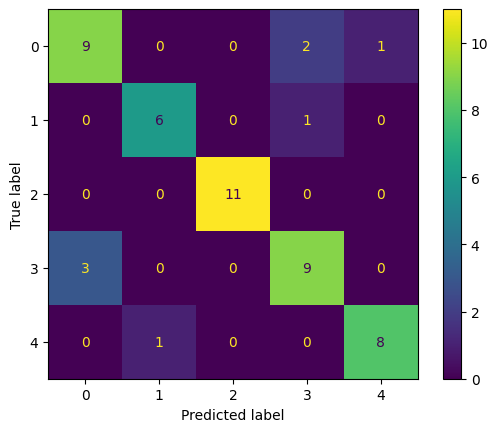


Hard cases for the model:

Label: boredom(0)
Hard cases of false positives: ['neutral(3)']

Label: neutral(3)
Hard cases of false negatives: ['boredom(0)']



In [6]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True, emotions='5emos')

Do the same with the 90-10 train-test split.

In [7]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos, test_size=0.1)

A snippet of the training data:


,energy_max,energy_mean,energy_var,energy_rising_duration_max,energy_rising_duration_mean,energy_rising_duration_median,energy_rising_duration_iqr,energy_falling_duration_max,energy_falling_duration_mean,energy_falling_duration_median,...,lpcmfccs_local9_max,lpcmfccs_local9_min,lpcmfccs_local10_mean,lpcmfccs_local10_var,lpcmfccs_local10_max,lpcmfccs_local10_min,lpcmfccs_local11_mean,lpcmfccs_local11_var,lpcmfccs_local11_max,lpcmfccs_local11_min
102,2.440066,0.809484,0.662290,1.038493,1.221491,-0.346349,-1.465294,0.052496,1.627077,0.527738,...,0.220540,0.197275,-0.350249,-0.094845,-0.200153,-0.186488,-0.408133,-0.071523,-0.202954,-0.228190
53,-0.959314,0.613678,-0.366092,0.564033,-0.673290,-1.544435,0.700307,0.388276,-1.045890,-1.948430,...,-0.630595,0.122621,0.529800,-0.249467,-0.103445,0.603975,0.578454,-0.266005,-0.156017,0.636512
303,2.440066,1.530193,0.500537,-0.859346,0.384195,0.252694,0.158907,1.059834,1.956355,1.765822,...,0.155025,0.194212,-0.232478,-0.139021,-0.200809,-0.122690,-0.289573,-0.123887,-0.183898,-0.162291
24,-0.959314,-1.651078,-1.749471,0.564033,-1.466754,-1.544435,-0.382494,0.724055,-1.655087,-1.948430,...,-0.384799,0.078785,0.381732,-0.244781,-0.049103,0.389247,0.386225,-0.258489,-0.117118,0.383776
225,0.173813,-1.068863,-0.337114,-1.333805,-0.748617,-0.346349,-1.465294,-1.290620,-0.842512,0.527738,...,-0.248547,-3.239745,0.324050,-0.237815,3.395994,0.263107,0.318203,-0.249077,3.060619,0.245260


There are 305 entries with 186 columns in the training data.
There are 34 entries with 186 columns in the testing data.


In [8]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
96.69% for the train data
89.33% for the test data

Evaluation: accuracy_score
96.39% for the train data
88.24% for the test data

Evaluation: precision_score
96.93% for the train data
91.14% for the test data

Evaluation: recall_score
96.51% for the train data
88.50% for the test data

Evaluation: confusion_matrix of test predictions


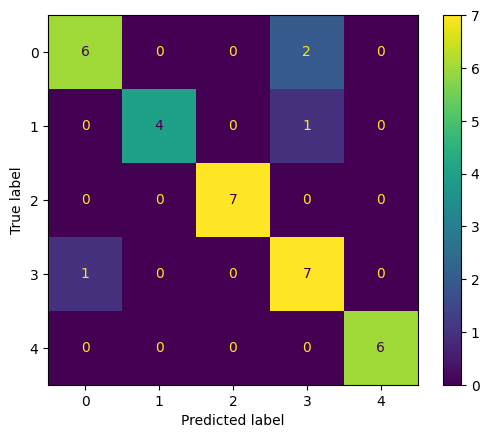


Hard cases for the model:

Label: boredom(0)
Hard cases of false negatives: ['neutral(3)']



In [10]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True, emotions='5emos')

Finally, we see that the model is even better with 5 emotions only. In this case, a 90-10 train-test split event improves the performance slighty. Only with *boredom* and *neutral* it has a hard time. Neverthesless, we are interested in comparing models' perfomances across all 7 emotions in EmoDB which is why we will move on with this dataset (and a 85-15 train-test split) from now on.

### Test the model performance with a selection of features as in paper 3
### 1) Only energy and pitch

A snippet of the training data:


,energy_max,energy_mean,energy_var,energy_rising_duration_max,energy_rising_duration_mean,energy_rising_duration_median,energy_rising_duration_iqr,energy_falling_duration_max,energy_falling_duration_mean,energy_falling_duration_median,...,pitch_falling_duration_median,pitch_falling_duration_iqr,pitch_rising_value_max,pitch_rising_value_mean,pitch_rising_value_median,pitch_rising_value_iqr,pitch_falling_value_max,pitch_falling_value_mean,pitch_falling_value_median,pitch_falling_value_iqr
241,0.109759,1.184469,1.719364,-0.317983,-1.221313,-1.011377,-0.026398,-0.931386,-0.958430,-0.022437,...,-0.834149,0.180696,-1.329934,-1.360738,-0.868603,-0.968879,0.318704,1.288659,0.869517,-0.927559
364,-0.957895,-1.575339,-1.830023,-0.317983,-1.094613,-0.403414,-0.297992,-1.288073,-0.602240,0.609351,...,-0.072163,-0.040017,1.092121,-1.212129,-0.779508,-0.960817,0.301543,1.138816,0.619213,-0.778304
209,-0.957895,-1.598139,-1.561260,-0.790542,-0.346797,0.812510,-0.841179,-1.288073,-0.941656,0.609351,...,-0.326159,0.622122,-1.010090,-0.470421,0.382565,-0.181758,0.082893,0.175622,-0.004860,-0.159984
430,-0.957895,-0.070193,-0.489470,-1.263100,-0.811046,0.812510,-0.297992,-1.288073,-0.852198,0.609351,...,0.689823,-0.260730,-0.933011,0.570475,1.485465,0.054747,0.317400,-0.453870,-0.454121,0.375208
309,2.245066,0.775073,0.472092,1.099692,-0.354158,-0.403414,1.331571,-1.288073,-1.393016,-1.917803,...,1.705805,-0.260730,0.244524,0.961703,0.725649,-0.034439,-0.551866,-0.935010,-1.252798,0.113163


There are 454 entries with 38 columns in the training data.
There are 81 entries with 38 columns in the testing data.

Evaluation: f1_score
81.50% for the train data
45.90% for the test data

Evaluation: accuracy_score
82.38% for the train data
51.85% for the test data

Evaluation: precision_score
84.12% for the train data
48.00% for the test data

Evaluation: recall_score
80.13% for the train data
47.04% for the test data

Evaluation: confusion_matrix of test predictions


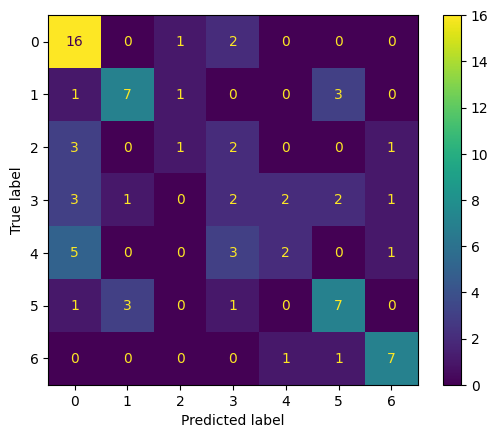


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)', 'fear(3)']
Hard cases of false positives: ['anger(0)', 'boredom(1)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)', 'fear(3)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [26]:
# select the features
df_3_ep = df_3.filter(regex='energy_|pitch_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_ep)

# train the model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

We get 81.50% F1 macro compared to 66.02% recognition rate with 5 emotions and 90-10 train-test split in paper 3.
### 2) Only LPCMFCC


Evaluation: f1_score
40.51% for the train data
35.97% for the test data

Evaluation: accuracy_score
49.56% for the train data
49.38% for the test data

Evaluation: precision_score
54.60% for the train data
36.40% for the test data

Evaluation: recall_score
43.45% for the train data
41.96% for the test data

Evaluation: confusion_matrix of test predictions


C:\Users\Kim-Carolin\anaconda3\envs\automatic_speech_emotion_recognition\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


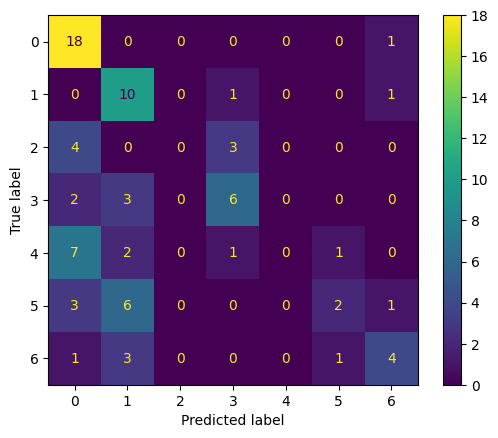


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)', 'fear(3)']

Label: fear(3)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['anger(0)', 'boredom(1)']
Hard cases of false positives: ['happiness(4)', 'sadness(6)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']



In [28]:
# select the features
df_3_lpcmfcc = df_3.filter(regex='lpcmfccs_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_lpcmfcc, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

The LPCMFCC features alone don't seem to be very good or at least not sufficient enough. The model has a hard time at predicting emotions other than *anger* and *boredom*. We get 40.51% F1 macro compared to 70.7% recognition rate with 5 emotions and 90-10 train-test split in paper 3.


Evaluation: f1_score
55.03% for the train data
46.75% for the test data

Evaluation: accuracy_score
55.95% for the train data
48.15% for the test data

Evaluation: precision_score
56.72% for the train data
49.15% for the test data

Evaluation: recall_score
56.14% for the train data
47.55% for the test data

Evaluation: confusion_matrix of test predictions


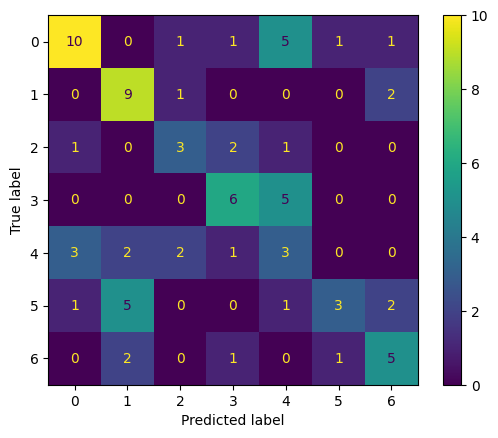


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)', 'fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']



In [29]:
# change the model's hyperparameter
# train the model
svm_model = SVC(C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Especially balancing but also the other hyperparamaters can improve the model. Nevertheless, we are not as good as in paper 3. 
<br>  How about when we only use 5 emotions?


Evaluation: f1_score
62.34% for the train data
54.97% for the test data

Evaluation: accuracy_score
61.97% for the train data
52.94% for the test data

Evaluation: precision_score
63.42% for the train data
57.90% for the test data

Evaluation: recall_score
63.75% for the train data
56.71% for the test data

Evaluation: confusion_matrix of test predictions


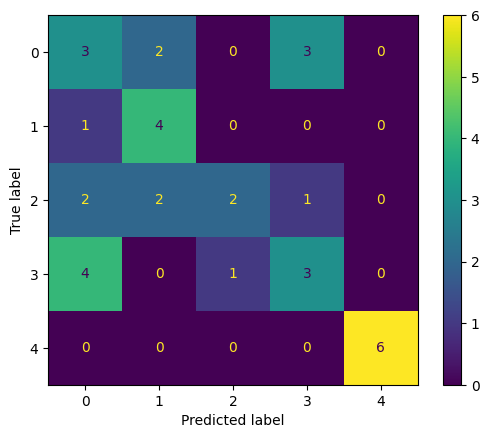


Hard cases for the model:

Label: boredom(0)
Hard cases of false negatives: ['disgust(1)', 'neutral(3)']
Hard cases of false positives: ['neutral(3)']

Label: disgust(1)
Hard cases of false positives: ['boredom(0)', 'happiness(2)']

Label: happiness(2)
Hard cases of false negatives: ['boredom(0)', 'disgust(1)']
Hard cases of false positives: ['neutral(3)']

Label: neutral(3)
Hard cases of false negatives: ['boredom(0)']
Hard cases of false positives: ['boredom(0)']



In [27]:
# load the train/test data
df_5emos_lpcmfccs = df_5emos.filter(regex='lpcmfccs_|label')
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos_lpcmfccs, test_size=0.1, verbose=False)

# train the model
svm_model = SVC(C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True, emotions='5emos')

We are getting closer to the results in paper 3 for LPCMFCC features only. We can see that the hyperparameters have a huge impact for the model to capture the features in the best manner.

### 3) energy, pitch, LPCC, MFCC


Evaluation: f1_score
95.27% for the train data
74.68% for the test data

Evaluation: accuracy_score
95.15% for the train data
76.54% for the test data

Evaluation: precision_score
96.03% for the train data
80.73% for the test data

Evaluation: recall_score
94.70% for the train data
73.06% for the test data

Evaluation: confusion_matrix of test predictions


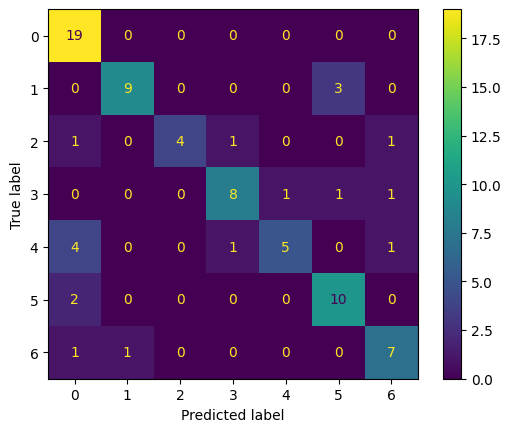


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [9]:
# select the features
df_3_eplm = df_3.filter(regex='energy_|pitch_|lpccs_|^mfccs|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplm, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

### 4) energy, pitch, LPCMFCC


Evaluation: f1_score
77.58% for the train data
42.16% for the test data

Evaluation: accuracy_score
78.63% for the train data
48.15% for the test data

Evaluation: precision_score
80.31% for the train data
44.54% for the test data

Evaluation: recall_score
76.41% for the train data
42.98% for the test data

Evaluation: confusion_matrix of test predictions


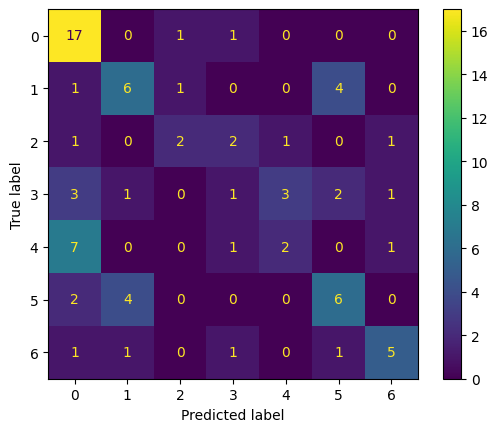


Hard cases for the model:

Label: anger(0)
Hard cases of false positives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['anger(0)', 'boredom(1)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)', 'happiness(4)']
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [6]:
# select the features
df_3_eplpcmfcc = df_3.filter(regex='energy_|pitch_|lpcmfccs_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplpcmfcc, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Finally, it seems like the model with Energy, pitch, lpccs, and mfccs is the strongest. It could be that the computation of lpcmfccs is not sufficient enough to hold both advantages of lpccs and mfccs in this case. We will try if further finetuning for the best model still increases its performance.

### Hyperparameter Optimization best model 

In [8]:
# train model on best features again

# select the features
df_3_eplm = df_3.filter(regex='energy_|pitch_|lpccs_|^mfccs|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplm, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# define the grid for the hyperparameter search
grid_vals = { 'C': [0.01, 0.1, 1, 10], 
            'gamma': [0.01, 0.1, 1, 10, 'scale', 'auto'],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'class_weight': ['balanced', None], 
            'decision_function_shape': ['ovo', 'ovr']
            }

run_gridsearchCV(svm_model, grid_vals, X_train, y_train, name_spec='paper3')

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_we

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, 

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; tot

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total t

[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None

[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[C

[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=linear; total time= 

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1,

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total ti

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=li

[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_

[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight

[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_functio

[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=1, class_

[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END 

[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weigh

[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_fu

[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weigh

[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_func

[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=linear; to

[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=lin

[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=bala

[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=Non

[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, class

[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=Non

[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=sigmoid; total time=   0.0s

Best hyperparameters 


Evaluation: f1_score
89.79% for the train data
72.83% for the test data

Evaluation: accuracy_score
89.43% for the train data
75.31% for the test data

Evaluation: precision_score
89.83% for the train data
74.94% for the test data

Evaluation: recall_score
89.78% for the train data
72.20% for the test data

Evaluation: confusion_matrix of test predictions


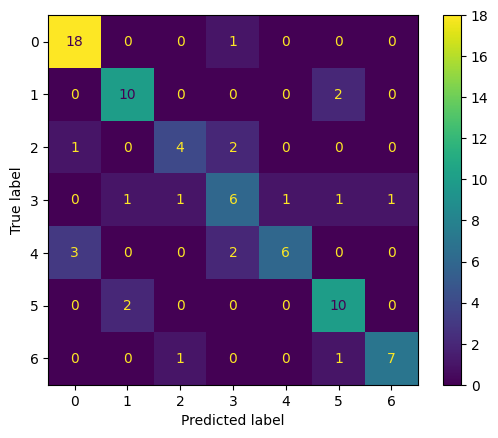


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [11]:
svm_best_model_paper3 = load_model(svm_model, 'f1_macro', name_spec='paper3')
model_eval(svm_best_model_paper3, X_train, X_test, y_train, y_test, confusion=True)

In [16]:
params_best_svm = svm_best_model_paper3.get_params()
params_best_svm

{'C': 0.01,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 0.01,
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Even though we already achieve quite good results, we can still see that the model is overfitting to our data. Therefore, we will apply some dimensionality reduction/ feature selection.
## Dimensionality Reduction (Feature Selection)
### 1) PCA

In [12]:
# create the dataset of principal components
pca = PCA(0.9)
principalComponents = pca.fit_transform(df_3.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df_3[['label']]], axis = 1)

In [13]:
len(pca.explained_variance_ratio_)

34

In [14]:
pca.explained_variance_ratio_.sum()

0.9009038857850062


Evaluation: f1_score
89.47% for the train data
74.35% for the test data

Evaluation: accuracy_score
89.43% for the train data
76.54% for the test data

Evaluation: precision_score
90.92% for the train data
79.99% for the test data

Evaluation: recall_score
88.55% for the train data
73.39% for the test data

Evaluation: confusion_matrix of test predictions


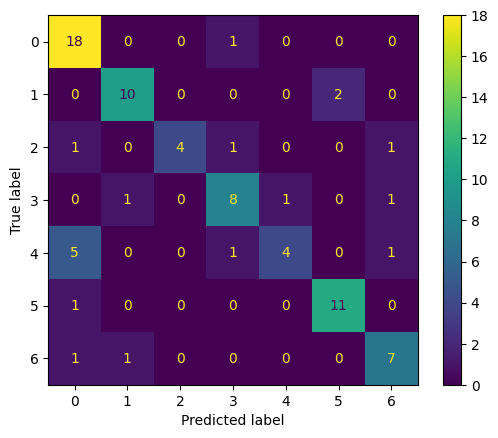


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [110]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Keeping 90% variance, we can end up with a good result for train and test data while using only 34 features (principal components) instead of 186! (89.47% compared to 95.27% F1 macro for train, 74.35% compared to 74.68% F1 macro for test

In [23]:
# try with all created numerical features:

# create the dataset of principal components
pca = PCA(0.9)
principalComponents = pca.fit_transform(df.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df[['label']]], axis = 1)

In [21]:
print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

45
[0.23581693 0.12877795 0.0674841  0.05460922 0.04606773 0.03023742
 0.02762442 0.02347436 0.02143095 0.02042869 0.01876905 0.0164818
 0.01424384 0.01370424 0.01228562 0.01129623 0.01083201 0.00998891
 0.00870228 0.00836442 0.00819394 0.00769889 0.00755193 0.00661629
 0.00633054 0.00598198 0.00553775 0.005205   0.00505599 0.00478569
 0.00465387 0.00460242 0.00457896 0.00436761 0.00431096 0.00419472
 0.0040822  0.00396837 0.00383107 0.00379615 0.00367262 0.0036514
 0.00338967 0.00330118 0.00327655]



Evaluation: f1_score
93.28% for the train data
78.42% for the test data

Evaluation: accuracy_score
93.17% for the train data
80.25% for the test data

Evaluation: precision_score
94.20% for the train data
84.01% for the test data

Evaluation: recall_score
92.65% for the train data
76.74% for the test data

Evaluation: confusion_matrix of test predictions


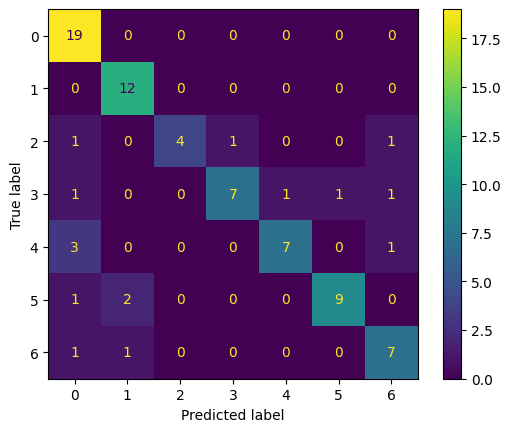


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [22]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

### 2) Featurewiz

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (535, 187)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

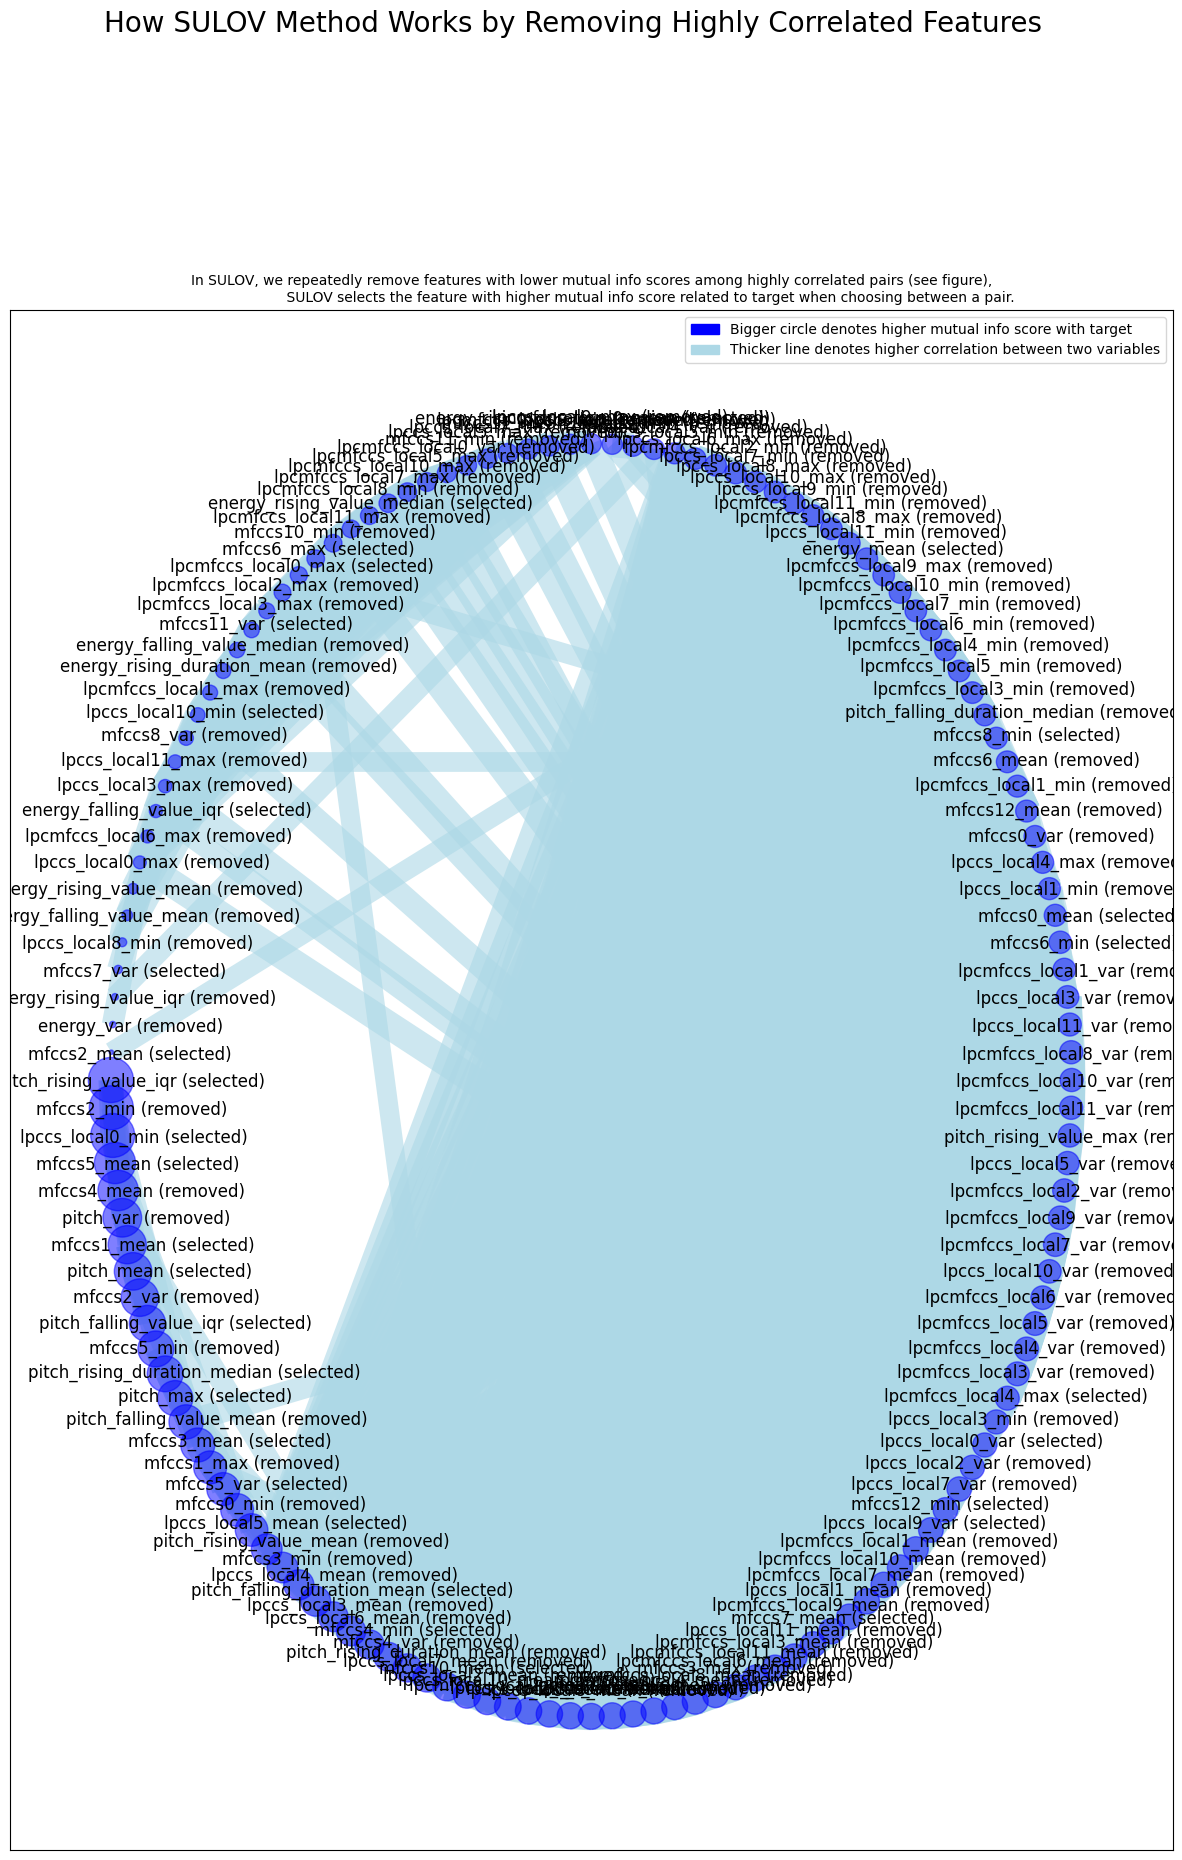

Time taken for SULOV method = 4 seconds
    Adding 0 categorical variables to reduced numeric variables  of 75
Finally 75 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 75 
    Taking top 27 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 75 variables...
            selecting 14 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
        using 60 variables...
            selecting 12 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds


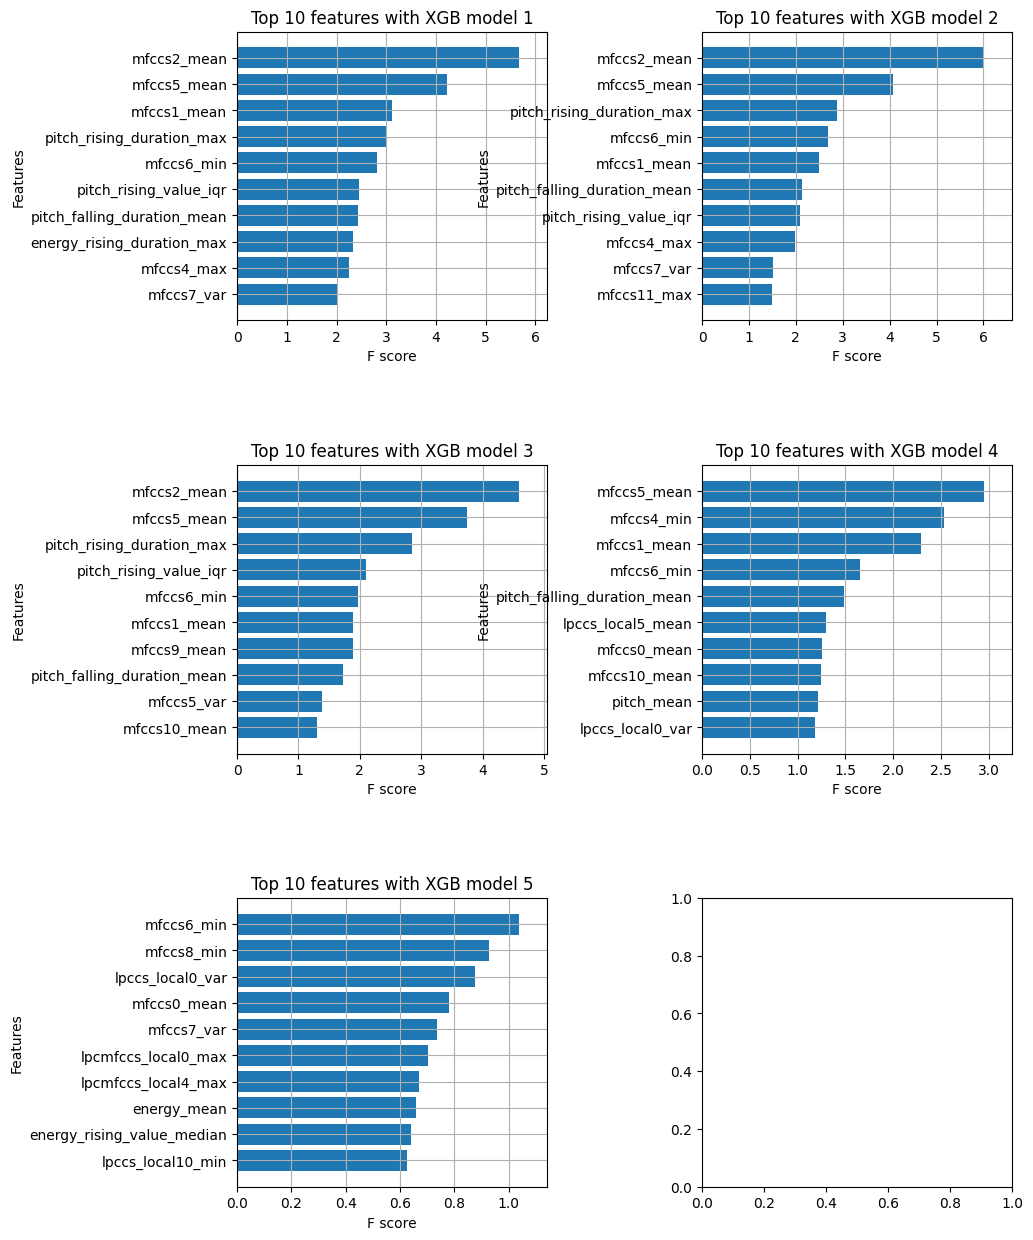

    Completed XGBoost feature selection in 2 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 20 important features:
['mfccs2_mean', 'mfccs5_mean', 'mfccs1_mean', 'pitch_rising_duration_max', 'mfccs6_min', 'pitch_rising_value_iqr', 'pitch_falling_duration_mean', 'energy_rising_duration_max', 'mfccs4_max', 'mfccs7_var', 'lpcmfccs_local0_max', 'mfccs0_mean', 'energy_falling_value_max', 'mfccs9_min', 'mfccs11_max', 'mfccs9_mean', 'mfccs5_var', 'mfccs10_mean', 'mfccs4_min', 'lpccs_local5_mean']
Total Time taken for featurewiz selection = 10 seconds
Output contains a list of 20 important features and a train dataframe


In [4]:
# automatic feature selection by using featurewiz package
target = 'label'
 
features, df_reduced = featurewiz(df_3, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [5]:
features

['mfccs2_mean',
 'mfccs5_mean',
 'mfccs1_mean',
 'pitch_rising_duration_max',
 'mfccs6_min',
 'pitch_rising_value_iqr',
 'pitch_falling_duration_mean',
 'energy_rising_duration_max',
 'mfccs4_max',
 'mfccs7_var',
 'lpcmfccs_local0_max',
 'mfccs0_mean',
 'energy_falling_value_max',
 'mfccs9_min',
 'mfccs11_max',
 'mfccs9_mean',
 'mfccs5_var',
 'mfccs10_mean',
 'mfccs4_min',
 'lpccs_local5_mean']


Evaluation: f1_score
87.03% for the train data
67.79% for the test data

Evaluation: accuracy_score
87.00% for the train data
69.14% for the test data

Evaluation: precision_score
88.11% for the train data
75.34% for the test data

Evaluation: recall_score
86.46% for the train data
67.87% for the test data

Evaluation: confusion_matrix of test predictions


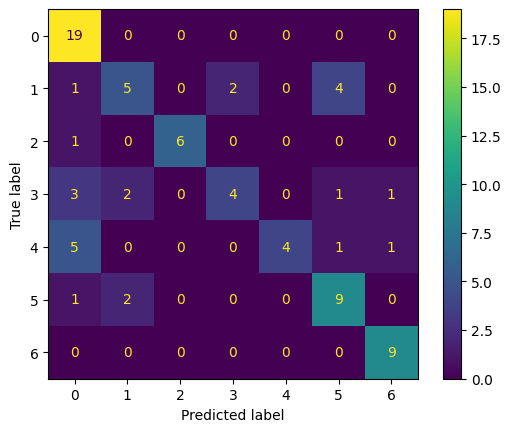


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['fear(3)', 'neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['boredom(1)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [6]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (535, 250)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

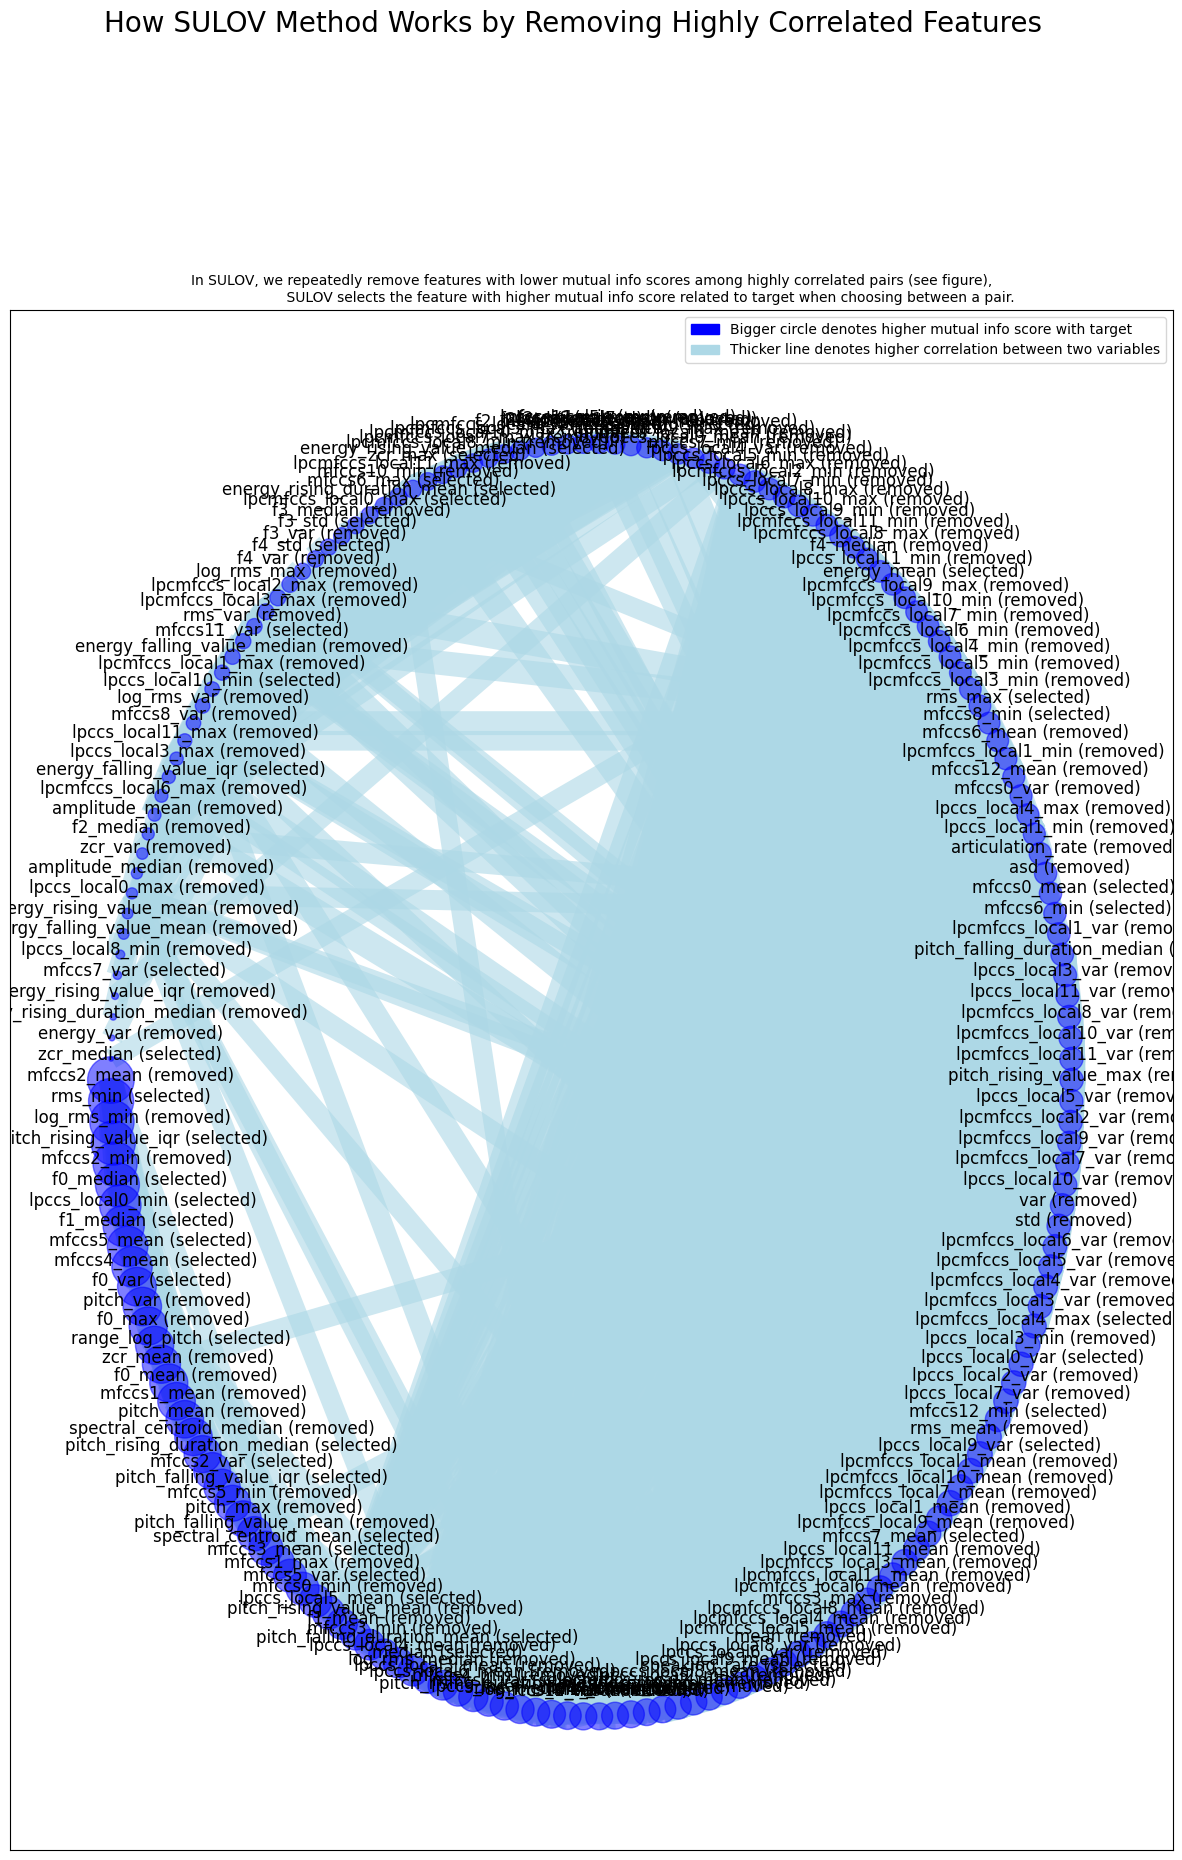

Time taken for SULOV method = 4 seconds
    Adding 0 categorical variables to reduced numeric variables  of 106
Finally 106 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 106 
    Taking top 37 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 106 variables...
            selecting 25 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
        using 85 variables...
            selecting 20 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seco

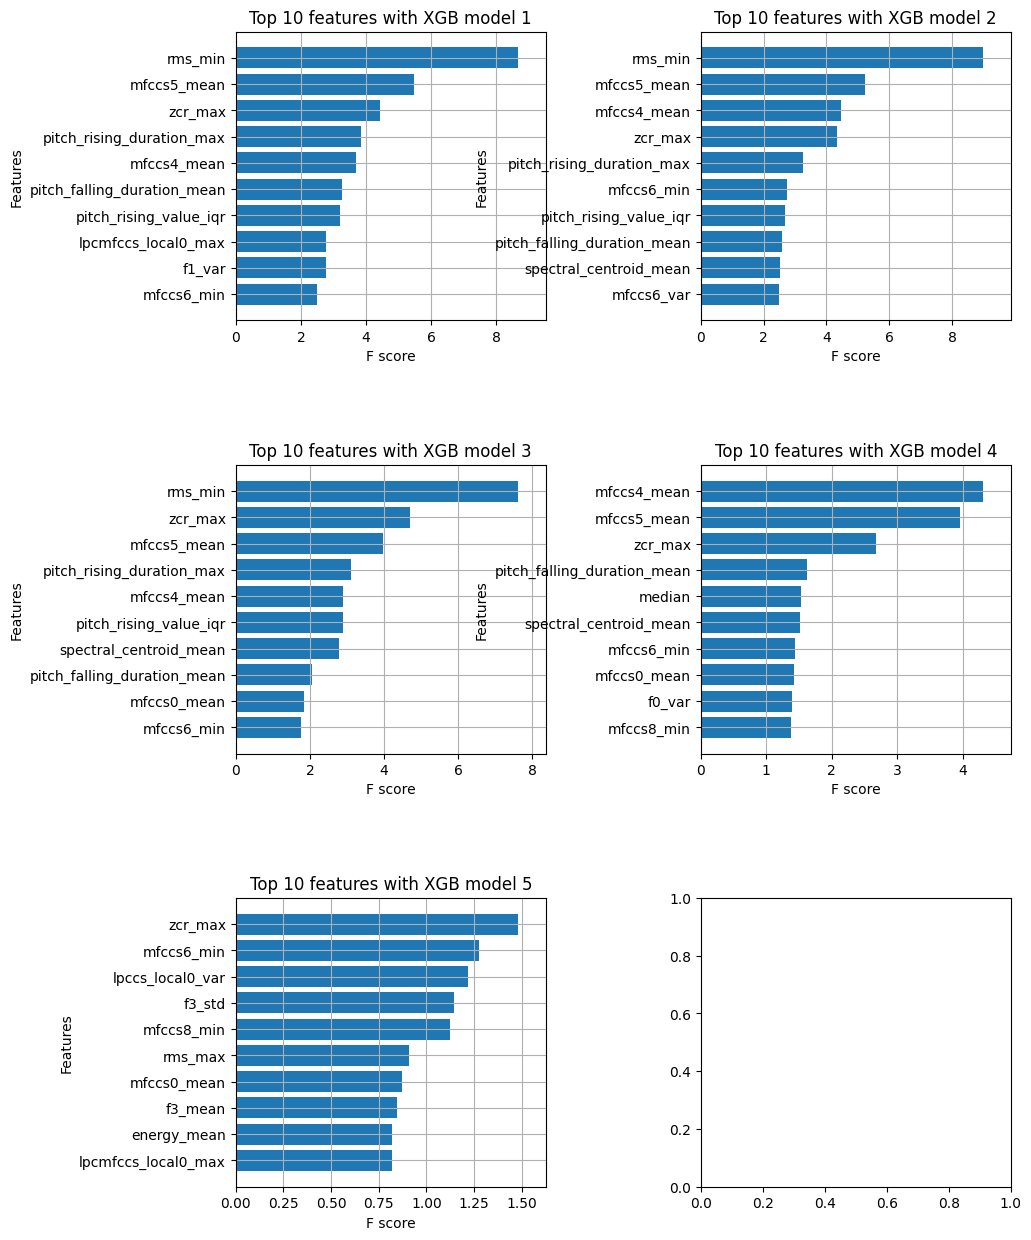

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 34 important features. Too many to print...
Total Time taken for featurewiz selection = 10 seconds
Output contains a list of 34 important features and a train dataframe


In [123]:
# try with all created numerical features:

# automatic feature selection by using featurewiz package
target = 'label'
 
features_all, df_reduced_all = featurewiz(df, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [124]:
features_all

['rms_min',
 'mfccs5_mean',
 'zcr_max',
 'pitch_rising_duration_max',
 'mfccs4_mean',
 'pitch_falling_duration_mean',
 'pitch_rising_value_iqr',
 'lpcmfccs_local0_max',
 'f1_var',
 'mfccs6_min',
 'pitch_falling_duration_max',
 'mfccs6_var',
 'lpccs_local5_mean',
 'energy_falling_value_max',
 'spectral_centroid_mean',
 'speaking_rate',
 'f0_var',
 'lpcmfccs_local4_max',
 'mfccs0_mean',
 'lpccs_local4_min',
 'pitch_falling_duration_iqr',
 'mfccs9_var',
 'mfccs4_max',
 'mfccs11_mean',
 'zcr_median',
 'skew_log_pitch',
 'rms_max',
 'mfccs11_max',
 'mfccs10_max',
 'f1_median',
 'median',
 'mfccs8_min',
 'lpccs_local0_var',
 'f3_std']


Evaluation: f1_score
91.54% for the train data
64.11% for the test data

Evaluation: accuracy_score
91.63% for the train data
66.67% for the test data

Evaluation: precision_score
92.04% for the train data
68.93% for the test data

Evaluation: recall_score
91.28% for the train data
63.50% for the test data

Evaluation: confusion_matrix of test predictions


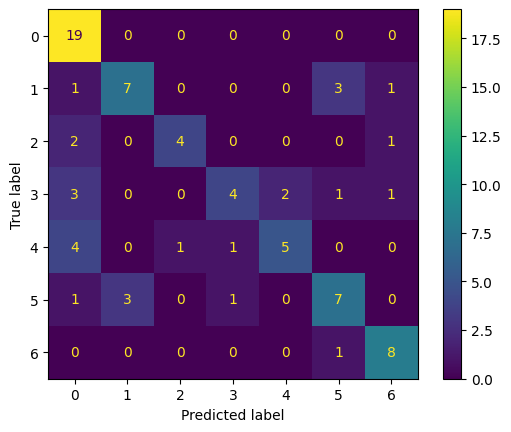


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [125]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced_all, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

With only 34 features we can achieve 91.54% F1 macro for the train data and 64.11% F1 macro for the test data!

## Feature Importance

In [10]:
def feature_importance(model, X_test, y_test, top=-1):
    from sklearn.inspection import permutation_importance
    if type(model).__name__ == 'SVC':
        kernel = model.get_params()['kernel']
        features = np.array(X_test.columns)
        if top == -1:
                top = len(features) # show all features
                
        if kernel == 'rbf':
            print('RBF kernel. Computing permutation importance.')
            perm_importance = permutation_importance(svm_model, X_test, y_test, random_state=0).importances_mean
            importance_sorted, features_sorted = zip(*sorted(zip(perm_importance, features))) # sorts in ascending order
            plt.barh(range(top), importance_sorted[::-1][:top][::-1], align='center')
            plt.yticks(range(top), features_sorted[::-1][:top][::-1])
            plt.title("Feature Permutation Importance")
            
        elif kernel == 'linear':
            importance = abs(model.coef_[0])
            importance_sorted, features_sorted = zip(*sorted(zip(importance, features)))
            plt.barh(range(top), importance_sorted[::-1][:top][::-1], align='center')
            plt.yticks(range(top), features_sorted[::-1][:top][::-1])
            plt.title("Feature Importance")
            
        plt.show()

RBF kernel. Computing permutation importance.


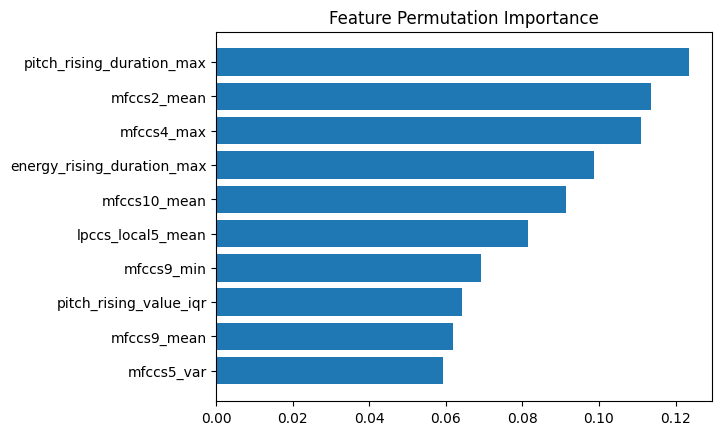

In [7]:
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced, verbose=False)
feature_importance(svm_model, X_test, y_test, top=10)

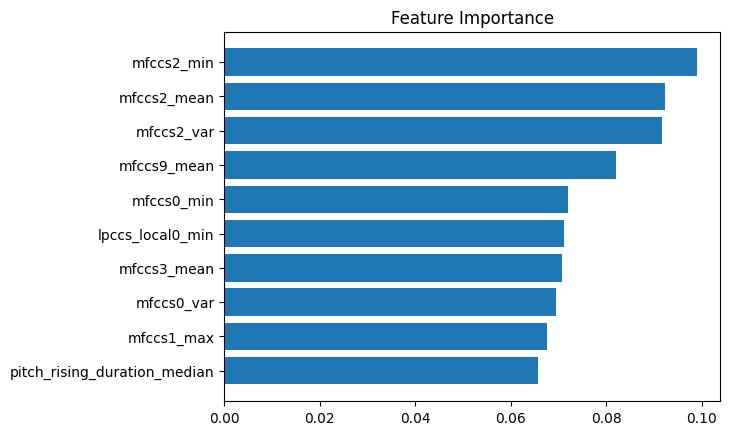

In [12]:
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplm, verbose=False)
feature_importance(svm_best_model_paper3, X_test, y_test, top=10)